# Post-processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from sklearn.linear_model import LinearRegression

VIDEO_NUMBER = "5"
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_CSV_PATH = str(PROJECT_ROOT / "notebook" / "spin" / "intermediate_data" / f"Rotation_data_{VIDEO_NUMBER}.csv")
INPUT_ORIGINAL_CSV = str(PROJECT_ROOT / "data" / "auxiliary_data" / "circle_positions" / f"Adjusted_positions_new_{VIDEO_NUMBER}.csv")

In [2]:
def show_plots(df):
    # Create subplots (1 row, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    # Plot x_axis
    axes[0].scatter(df['frame'], df['x_axis'], color='r')
    axes[0].set_title('X Axis per Frame')
    axes[0].set_xlabel('Frame')
    axes[0].set_ylabel('x_axis')
    axes[0].set_ylim(-1.1, 1.1)
    axes[0].grid(True)

    # Plot y_axis
    axes[1].scatter(df['frame'], df['y_axis'], color='g')
    axes[1].set_title('Y Axis per Frame')
    axes[1].set_xlabel('Frame')
    axes[1].set_ylabel('y_axis')
    axes[1].set_ylim(-1.1, 1.1)
    axes[1].grid(True)

    # Plot z_axis
    axes[2].scatter(df['frame'], df['z_axis'], color='b')
    axes[2].set_title('Z Axis per Frame')
    axes[2].set_xlabel('Frame')
    axes[2].set_ylabel('z_axis')
    axes[2].set_ylim(-1.1, 1.1)
    axes[2].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

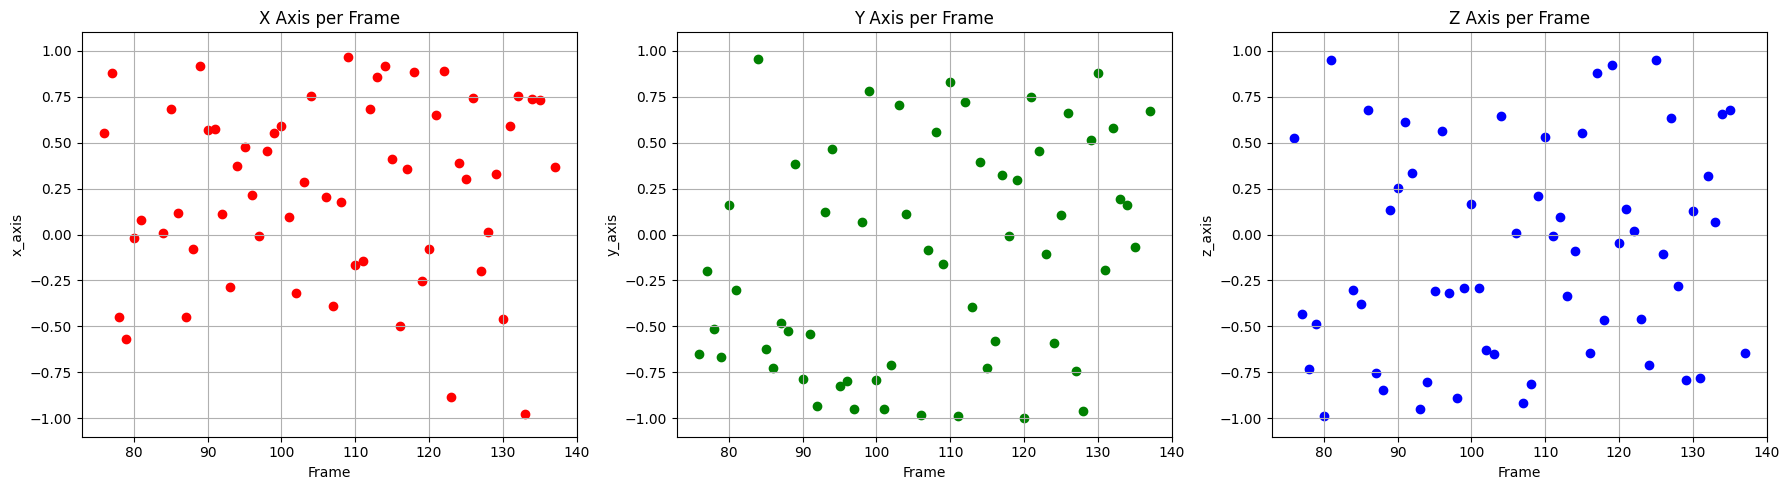

In [3]:
# Read the CSV data
df = pd.read_csv(INPUT_CSV_PATH)

show_plots(df)

Average z_axis value: -0.09444377744781536
Transformed rows where z_axis > 0.


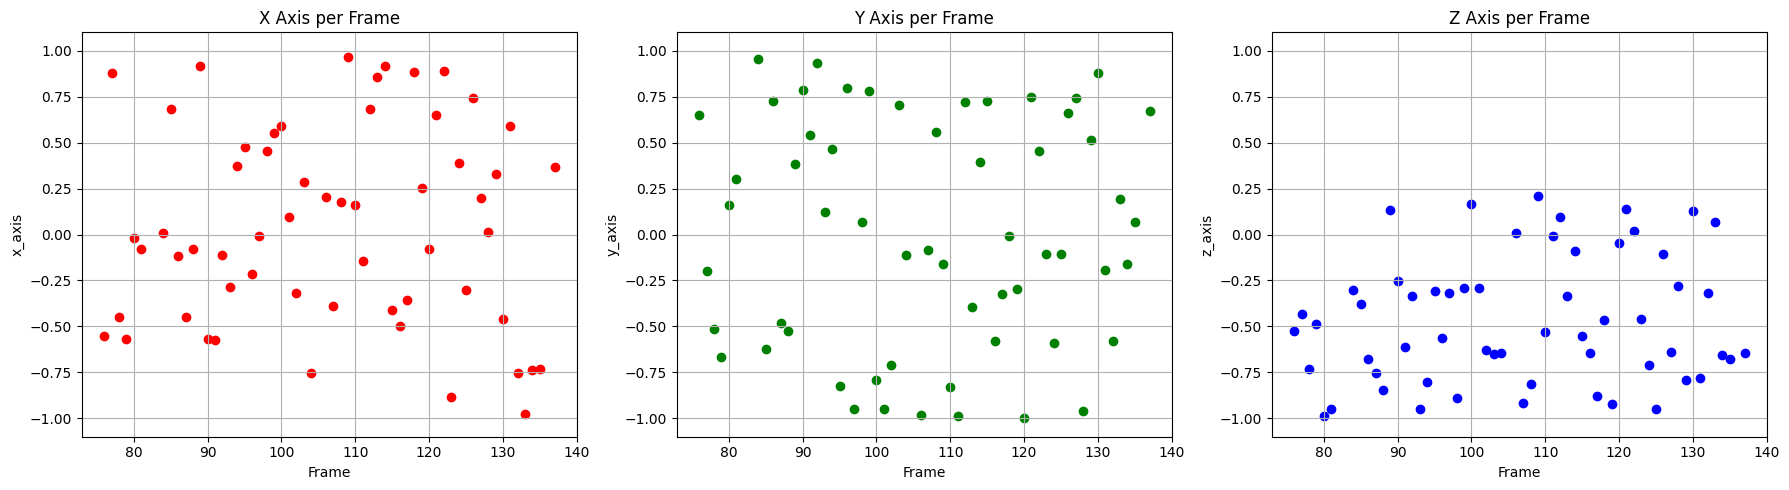

In [4]:
# Calculate average of z_axis
z_axis_avg = df['z_axis'].mean()

# Print the result
print(f"Average z_axis value: {z_axis_avg}")

if z_axis_avg < 0:
    # For rows where z_axis > 0, change the sign of x_axis, y_axis, and z_axis
    df.loc[df['z_axis'] > 0.25, ['x_axis', 'y_axis', 'z_axis']] *= -1
    print("Transformed rows where z_axis > 0.")
else:
    # For rows where z_axis < 0, change the sign of x_axis, y_axis, and z_axis
    df.loc[df['z_axis'] < 0.25, ['x_axis', 'y_axis', 'z_axis']] *= -1
    print("Transformed rows where z_axis < 0.")

show_plots(df)

Average y_axis value: 0.0008660297923382544
Cleaned 30 rows where y_axis was outside the acceptable range.


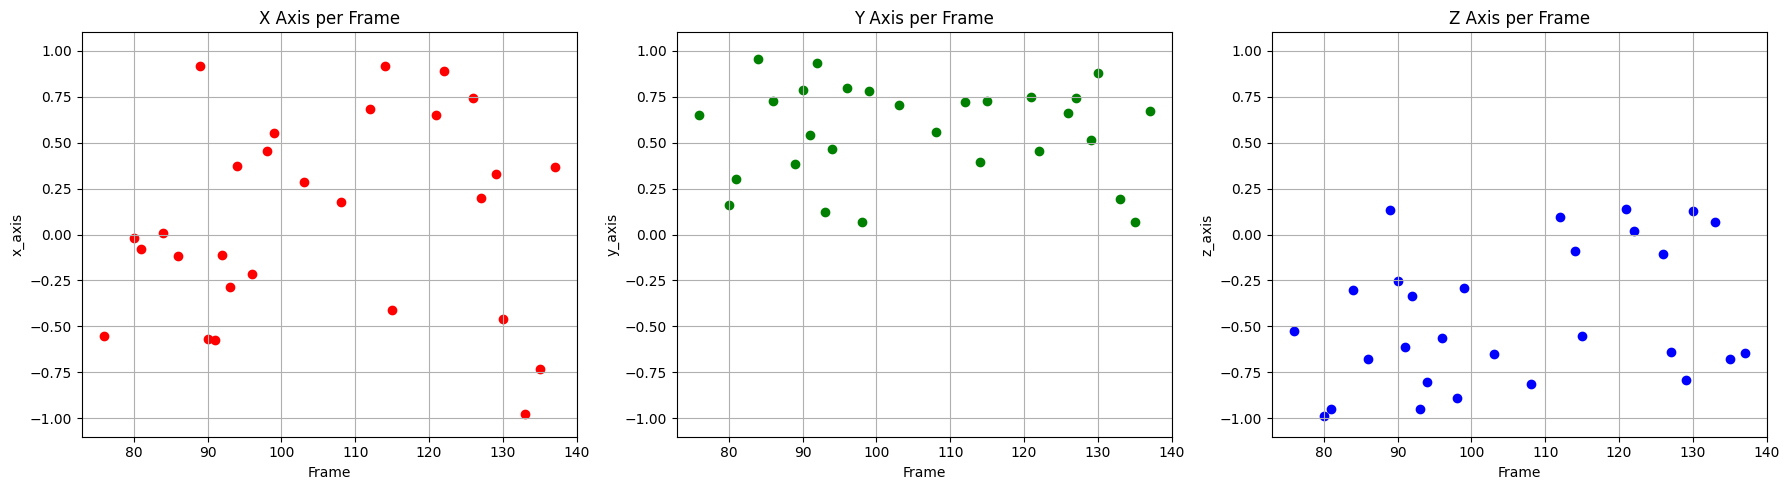

In [5]:
# y_axis_avg = df['y_axis'].mean()

# # Print the result
# print(f"Average y_axis value: {y_axis_avg}")

# if y_axis_avg < 0:
#     # Remove rows where y_axis > 0
#     df_y = df[df['y_axis'] <= -y_axis_avg].reset_index(drop=True)
#     removed = len(df) - len(df_y)
#     print(f"Removed {removed} rows where y_axis > 0.")
# else:
#     df_y = df[df['y_axis'] >= -y_axis_avg].reset_index(drop=True)
#     removed = len(df) - len(df_y)
#     print(f"Removed {removed} rows where y_axis < 0.")

y_axis_avg = df['y_axis'].mean()
print(f"Average y_axis value: {y_axis_avg}")

df_y = df.copy()

if y_axis_avg < 0:
    condition = df_y['y_axis'] > -y_axis_avg
else:
    condition = df_y['y_axis'] < -y_axis_avg

# Set values to NaN where the condition is met
columns_to_clean = ['x_axis', 'y_axis', 'z_axis', 'angle']
df_y.loc[condition, columns_to_clean] = np.nan

# Report how many rows were affected
cleaned = condition.sum()
print(f"Cleaned {cleaned} rows where y_axis was outside the acceptable range.")


show_plots(df_y)

Average x_axis value: 0.08687444511457201
Cleaned 14 rows where x_axis was outside the acceptable range.


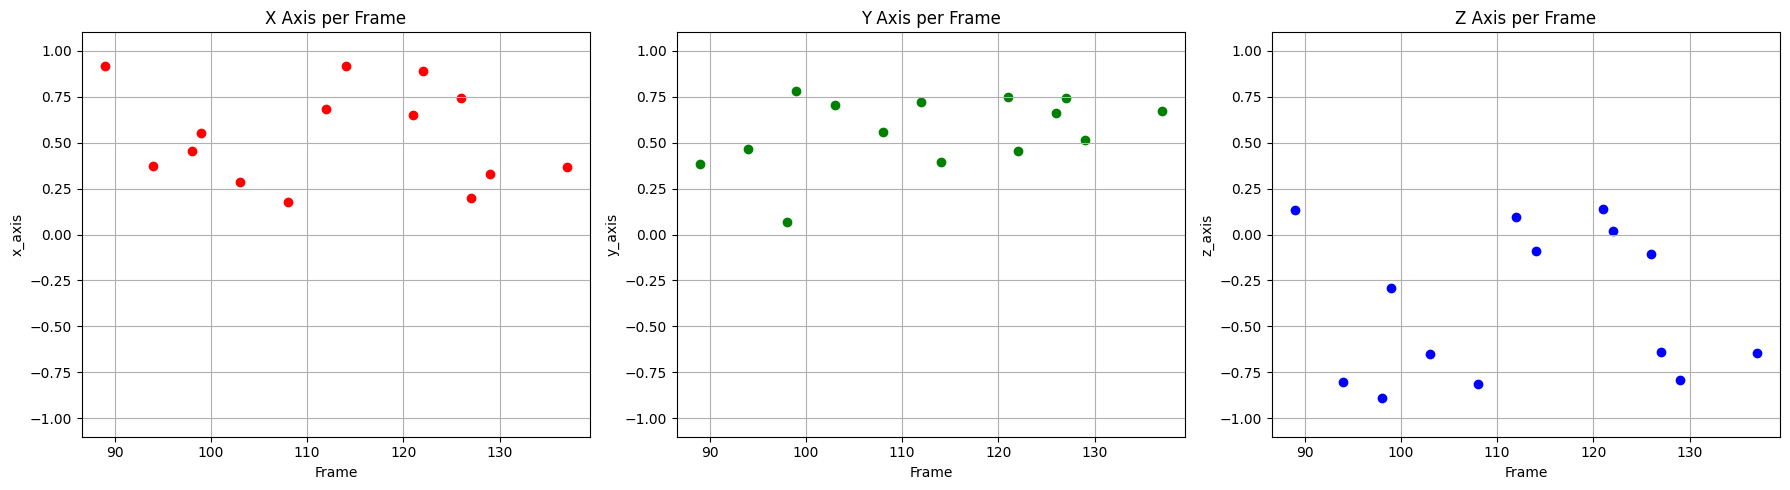

In [6]:
# x_axis_avg = df_y['x_axis'].mean()

# # Print the result
# print(f"Average x_axis value: {x_axis_avg}")

# if x_axis_avg < 0:
#     # Remove rows where y_axis > 0
#     df_x = df_y[df_y['x_axis'] <= -x_axis_avg].reset_index(drop=True)
#     removed = len(df_y) - len(df_x)
#     print(f"Removed {removed} rows where x_axis > 0.")
# else:
#     df_x = df_y[df_y['x_axis'] >= -x_axis_avg].reset_index(drop=True)
#     removed = len(df_y) - len(df_x)
#     print(f"Removed {removed} rows where x_axis < 0.")

import numpy as np

x_axis_avg = df_y['x_axis'].mean()
print(f"Average x_axis value: {x_axis_avg}")

df_x = df_y.copy()

if x_axis_avg < 0:
    condition = df_x['x_axis'] > -x_axis_avg +0.1
else:
    condition = df_x['x_axis'] < -x_axis_avg +0.1

# Set target columns to NaN where condition is met
columns_to_clean = ['x_axis', 'y_axis', 'z_axis', 'angle']
df_x.loc[condition, columns_to_clean] = np.nan

# Report cleaned rows
cleaned = condition.sum()
print(f"Cleaned {cleaned} rows where x_axis was outside the acceptable range.")


show_plots(df_x)

In [7]:
def show_plots_with_regression(full_df, filtered_df, threshold):
    # Drop rows with NaNs for regression fitting
    reg_df = full_df.dropna(subset=['frame', 'x_axis', 'y_axis'])

    # Fit regression lines on clean data
    x_model = LinearRegression()
    y_model = LinearRegression()
    x_model.fit(reg_df[['frame']], reg_df['x_axis'])
    y_model.fit(reg_df[['frame']], reg_df['y_axis'])

    # Predict over the same frames used in regression
    frames = reg_df['frame'].values.reshape(-1, 1)
    x_line = x_model.predict(frames)
    y_line = y_model.predict(frames)

    # Compute prediction errors only on reg_df
    x_error = np.abs(reg_df['x_axis'].values - x_line)
    y_error = np.abs(reg_df['y_axis'].values - y_line)
    is_outlier = (x_error > threshold) | (y_error > threshold)

    # Create subplots (1 row, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    # X Axis plot
    axes[0].scatter(reg_df['frame'][~is_outlier], reg_df['x_axis'][~is_outlier], color='green', label='Kept')
    axes[0].scatter(reg_df['frame'][is_outlier], reg_df['x_axis'][is_outlier], color='red', label='Outlier')
    axes[0].plot(reg_df['frame'], x_line, color='black', linestyle='--', label='Fit Line')
    axes[0].set_title('X Axis per Frame')
    axes[0].set_xlabel('Frame')
    axes[0].set_ylabel('x_axis')
    axes[0].set_ylim(-1.1, 1.1)
    axes[0].grid(True)
    axes[0].legend()

    # Y Axis plot
    axes[1].scatter(reg_df['frame'][~is_outlier], reg_df['y_axis'][~is_outlier], color='green', label='Kept')
    axes[1].scatter(reg_df['frame'][is_outlier], reg_df['y_axis'][is_outlier], color='red', label='Outlier')
    axes[1].plot(reg_df['frame'], y_line, color='black', linestyle='--', label='Fit Line')
    axes[1].set_title('Y Axis per Frame')
    axes[1].set_xlabel('Frame')
    axes[1].set_ylabel('y_axis')
    axes[1].set_ylim(-1.1, 1.1)
    axes[1].grid(True)
    axes[1].legend()

    # Z Axis plot (just show values from full_df)
    axes[2].scatter(full_df['frame'], full_df['z_axis'], color='b')
    axes[2].set_title('Z Axis per Frame')
    axes[2].set_xlabel('Frame')
    axes[2].set_ylabel('z_axis')
    axes[2].set_ylim(-1.1, 1.1)
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


In [8]:
def remove_outliers(df, threshold=0.50):
    df = df.copy()

    # Identify rows where x_axis and y_axis are valid
    valid_mask = df['x_axis'].notna() & df['y_axis'].notna()

    # Subset for regression
    valid_df = df[valid_mask]

    # Fit a line to x_axis vs frame
    x_model = LinearRegression()
    x_model.fit(valid_df[['frame']], valid_df['x_axis'])
    x_pred = x_model.predict(valid_df[['frame']])

    # Fit a line to y_axis vs frame
    y_model = LinearRegression()
    y_model.fit(valid_df[['frame']], valid_df['y_axis'])
    y_pred = y_model.predict(valid_df[['frame']])

    # Compute errors only for valid rows
    x_error = np.abs(valid_df['x_axis'] - x_pred)
    y_error = np.abs(valid_df['y_axis'] - y_pred)

    # Mask of values within threshold
    within_threshold = (x_error <= threshold) & (y_error <= threshold)

    # Set outliers in original DataFrame to NaN
    outlier_indices = valid_df.index[~within_threshold]
    df.loc[outlier_indices, ['x_axis', 'y_axis', 'z_axis', 'angle']] = np.nan

    # Report
    print(f"Cleaned {len(outlier_indices)} outlier rows based on threshold {threshold}.")

    return df

Cleaned 0 outlier rows based on threshold 0.5.


/home/davic/projects/IACV_project/bowling-analysis/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/davic/projects/IACV_project/bowling-analysis/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


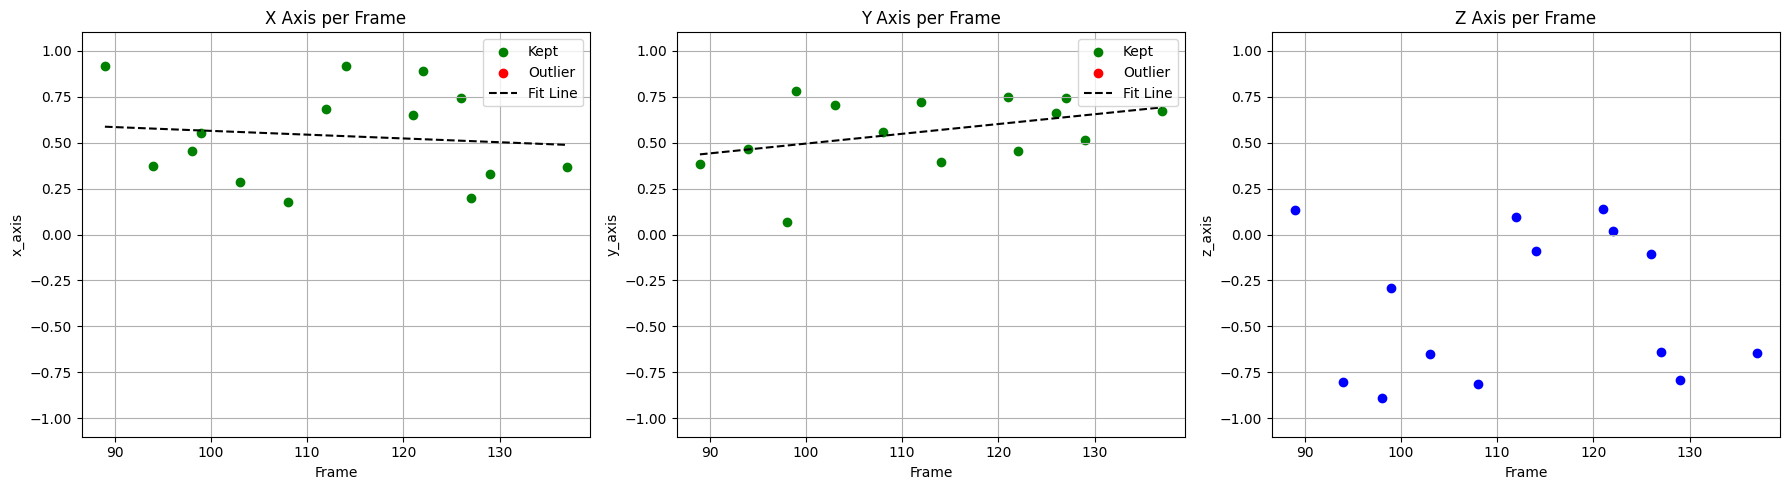

In [9]:
threshold = 0.5
fil_df = remove_outliers(df_x, threshold)

show_plots_with_regression(full_df=df_x, filtered_df=fil_df, threshold=threshold)

Cleaned 6 outlier rows based on threshold 0.3.


/home/davic/projects/IACV_project/bowling-analysis/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/davic/projects/IACV_project/bowling-analysis/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


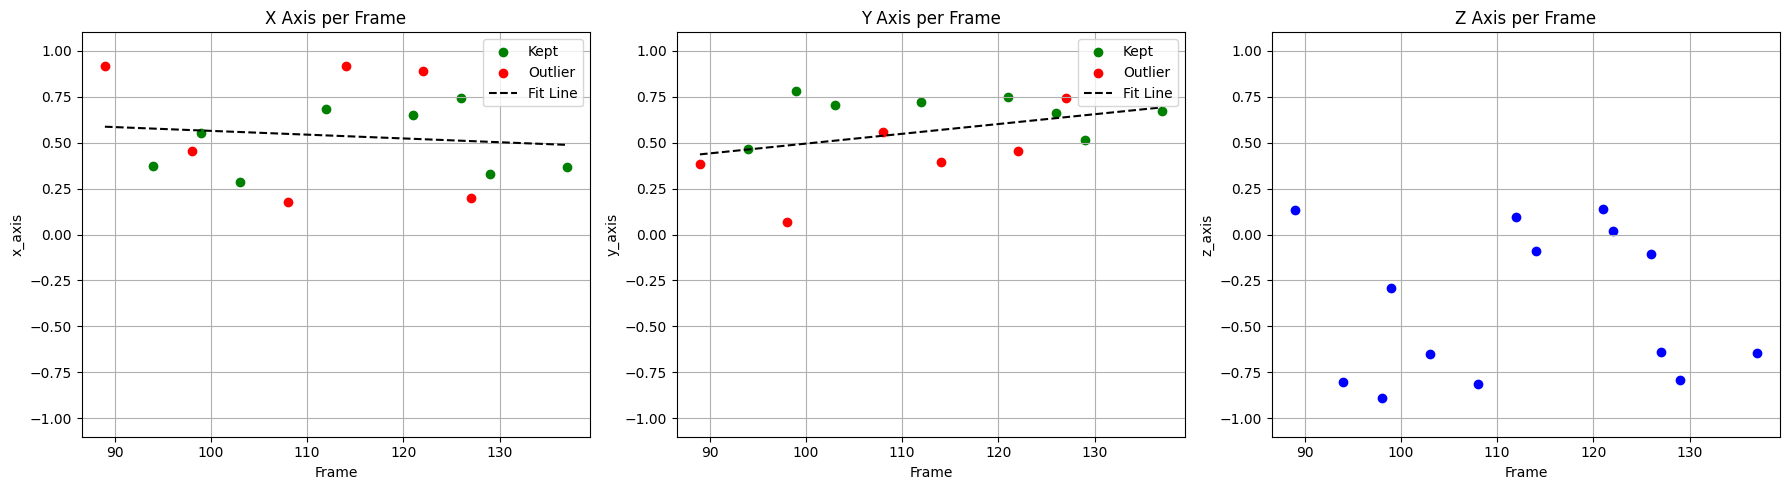

In [10]:
threshold = 0.3
filt_df = remove_outliers(fil_df, threshold)

show_plots_with_regression(full_df=fil_df, filtered_df=filt_df, threshold=threshold)

Cleaned 0 outlier rows based on threshold 0.3.


/home/davic/projects/IACV_project/bowling-analysis/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/davic/projects/IACV_project/bowling-analysis/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


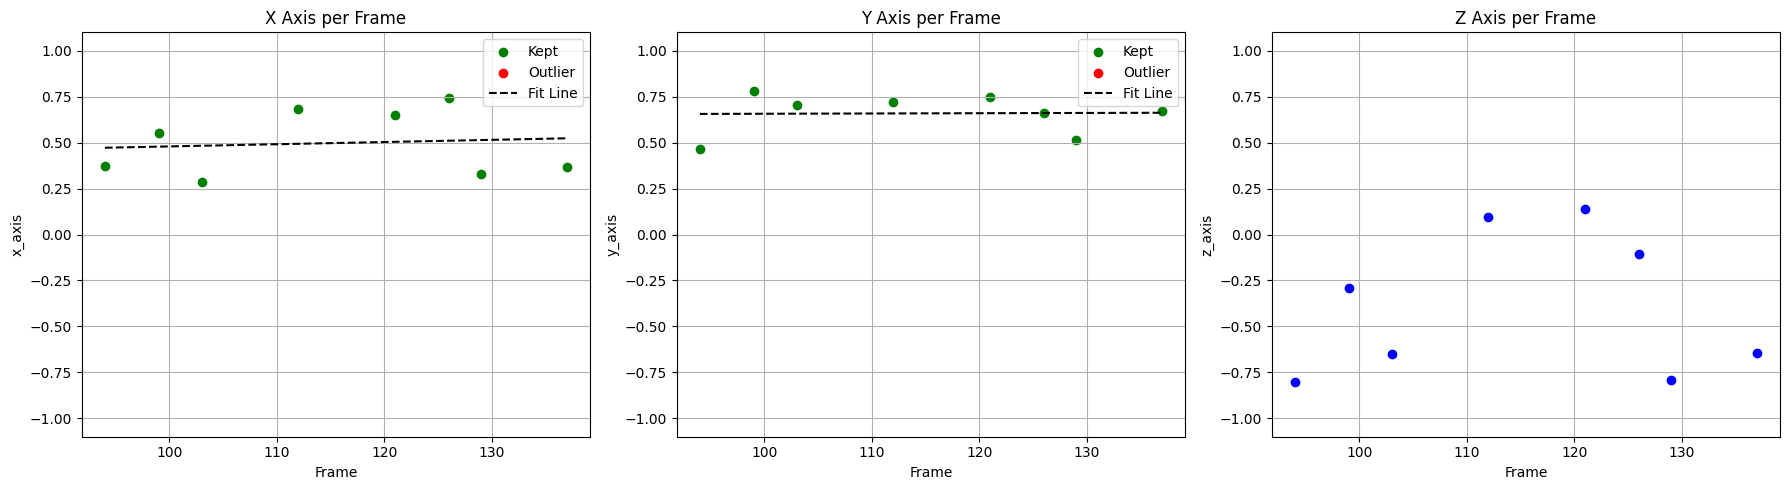

In [11]:
threshold = 0.3
filtered_df = remove_outliers(filt_df, threshold)

show_plots_with_regression(full_df=filt_df, filtered_df=filtered_df, threshold=threshold)

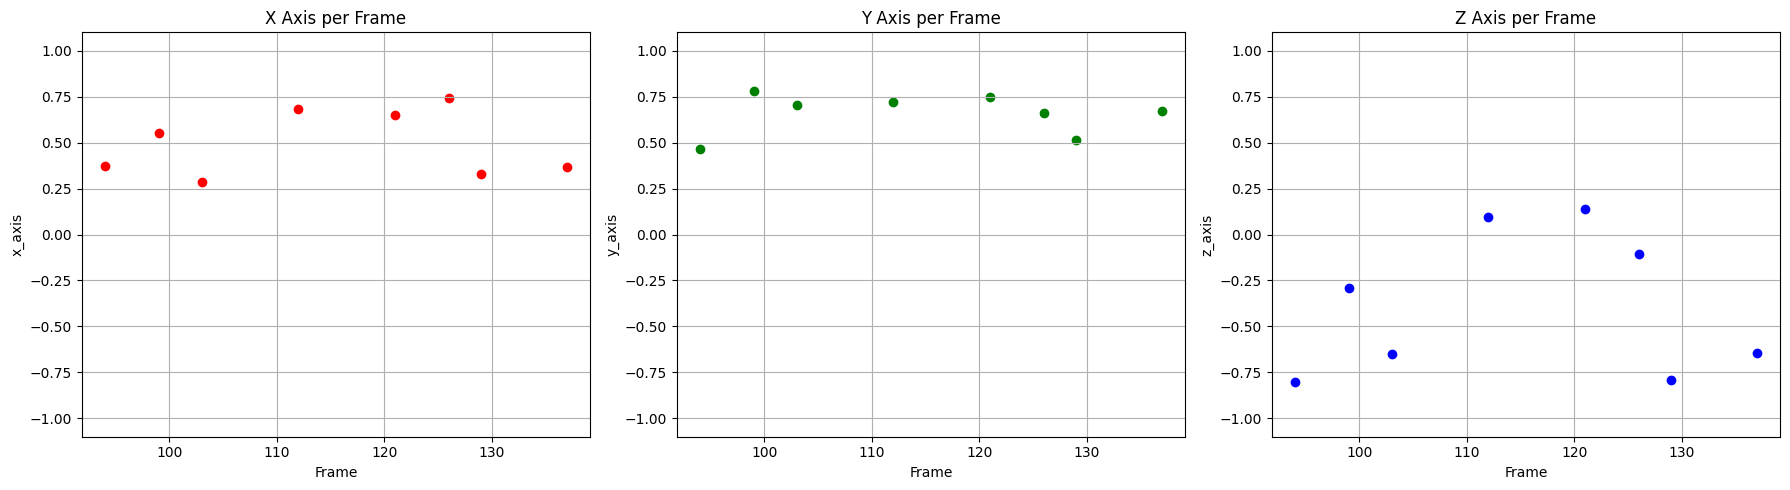

In [12]:
show_plots(filtered_df)

In [13]:
filtered_df.head

<bound method NDFrame.head of      frame   x   y  radius  x_axis  y_axis  z_axis  angle
0        0 NaN NaN     NaN     NaN     NaN     NaN    NaN
1        1 NaN NaN     NaN     NaN     NaN     NaN    NaN
2        2 NaN NaN     NaN     NaN     NaN     NaN    NaN
3        3 NaN NaN     NaN     NaN     NaN     NaN    NaN
4        4 NaN NaN     NaN     NaN     NaN     NaN    NaN
..     ...  ..  ..     ...     ...     ...     ...    ...
150    150 NaN NaN     NaN     NaN     NaN     NaN    NaN
151    151 NaN NaN     NaN     NaN     NaN     NaN    NaN
152    152 NaN NaN     NaN     NaN     NaN     NaN    NaN
153    153 NaN NaN     NaN     NaN     NaN     NaN    NaN
154    154 NaN NaN     NaN     NaN     NaN     NaN    NaN

[155 rows x 8 columns]>

In [14]:
def interpolate_axes_from_b(A, B):

    # Ensure 'frame' column exists in both
    if 'frame' not in A.columns or 'frame' not in B.columns:
        raise ValueError("Both CSVs must contain a 'frame' column.")

    # Identify frames in B where x and y are not NaN
    valid_frames = B.dropna(subset=['x', 'y'])['frame'].unique()

    # Make a copy to avoid modifying the original
    A_interp = A.copy()

    # Create a mask for valid frames in A
    valid_mask = A_interp['frame'].isin(valid_frames)

    for axis in ['x_axis', 'y_axis', 'z_axis']:
        # Work only with rows in A that correspond to valid frames
        axis_series = A_interp.loc[valid_mask, axis]

        # Interpolate based only on this subset
        interpolated_values = axis_series.interpolate(method='linear', limit_direction='both')

        # Assign the interpolated values back
        A_interp.loc[valid_mask, axis] = interpolated_values

    return A_interp

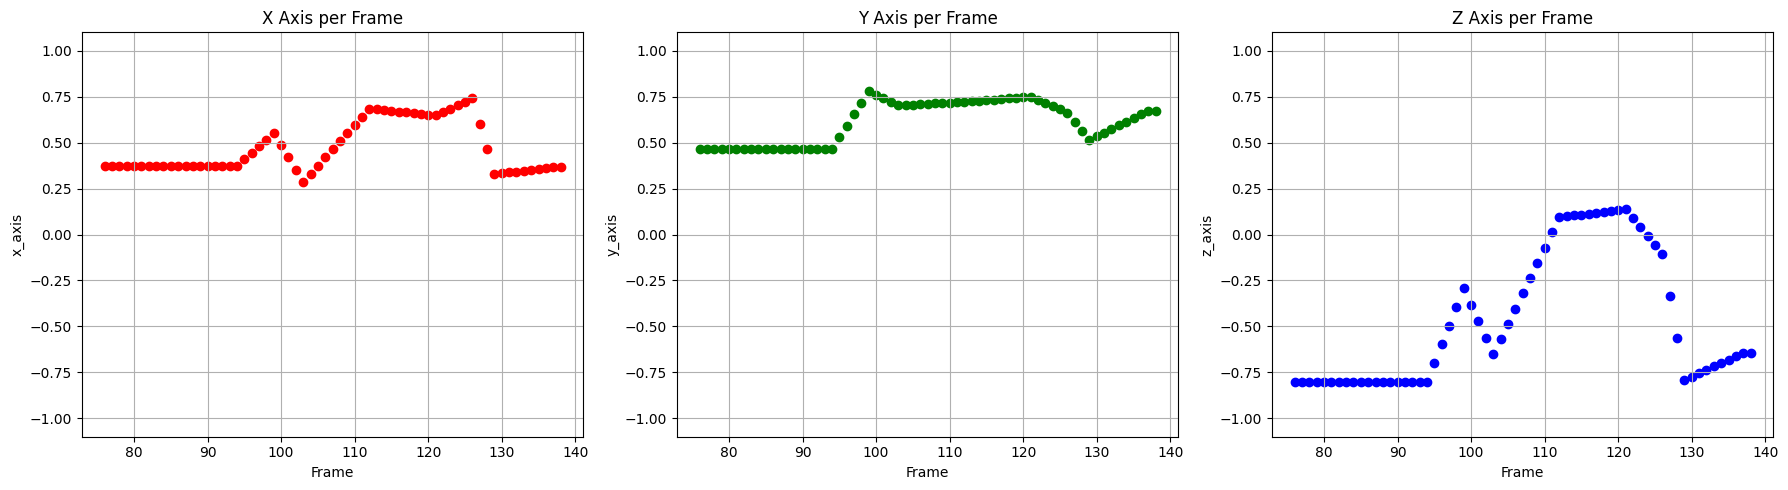

<bound method NDFrame.head of      frame   x   y  radius  x_axis  y_axis  z_axis  angle
0        0 NaN NaN     NaN     NaN     NaN     NaN    NaN
1        1 NaN NaN     NaN     NaN     NaN     NaN    NaN
2        2 NaN NaN     NaN     NaN     NaN     NaN    NaN
3        3 NaN NaN     NaN     NaN     NaN     NaN    NaN
4        4 NaN NaN     NaN     NaN     NaN     NaN    NaN
..     ...  ..  ..     ...     ...     ...     ...    ...
150    150 NaN NaN     NaN     NaN     NaN     NaN    NaN
151    151 NaN NaN     NaN     NaN     NaN     NaN    NaN
152    152 NaN NaN     NaN     NaN     NaN     NaN    NaN
153    153 NaN NaN     NaN     NaN     NaN     NaN    NaN
154    154 NaN NaN     NaN     NaN     NaN     NaN    NaN

[155 rows x 8 columns]>

In [15]:
df_original = pd.read_csv(INPUT_ORIGINAL_CSV)

result_df = interpolate_axes_from_b(filtered_df, df_original)
show_plots(result_df)
result_df.head

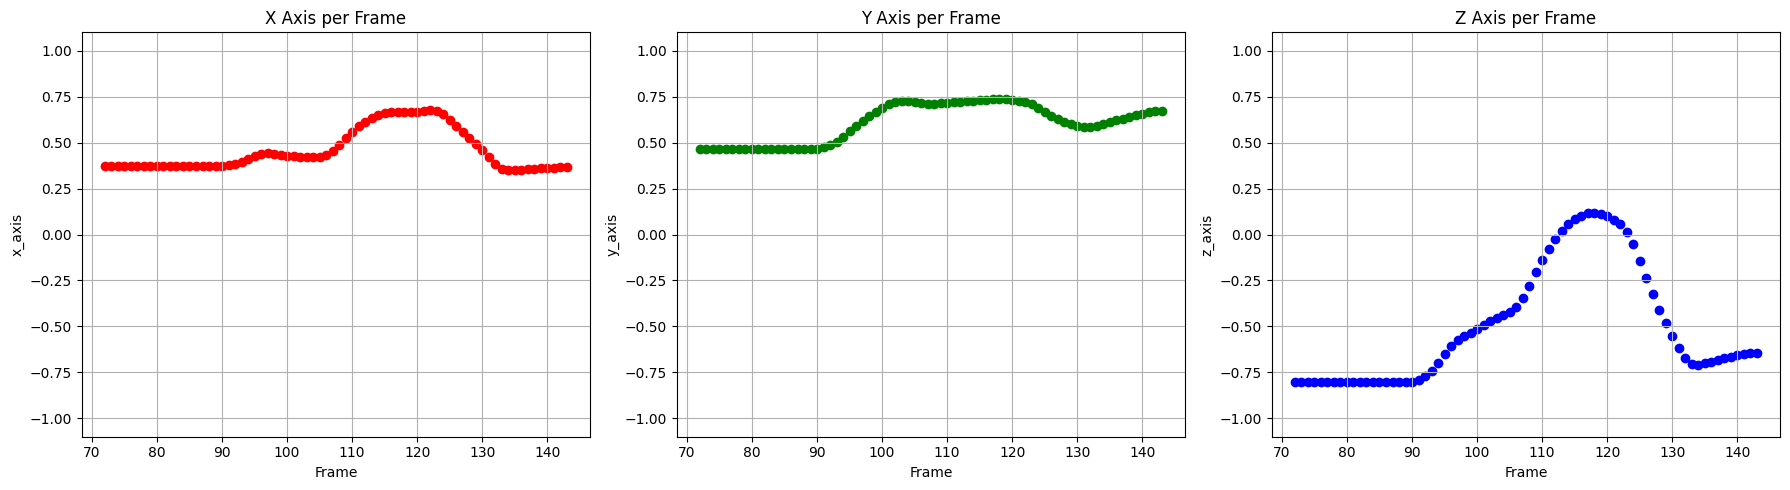

In [16]:
# Parameters
SMOOTHING_WINDOW = 10

# Apply rolling average to smooth each axis
smoothed_df = result_df.copy()
smoothed_df['x_axis'] = smoothed_df['x_axis'].rolling(window=SMOOTHING_WINDOW, center=True, min_periods=1).mean()
smoothed_df['y_axis'] = smoothed_df['y_axis'].rolling(window=SMOOTHING_WINDOW, center=True, min_periods=1).mean()
smoothed_df['z_axis'] = smoothed_df['z_axis'].rolling(window=SMOOTHING_WINDOW, center=True, min_periods=1).mean()

# Smoothed result
show_plots(smoothed_df)

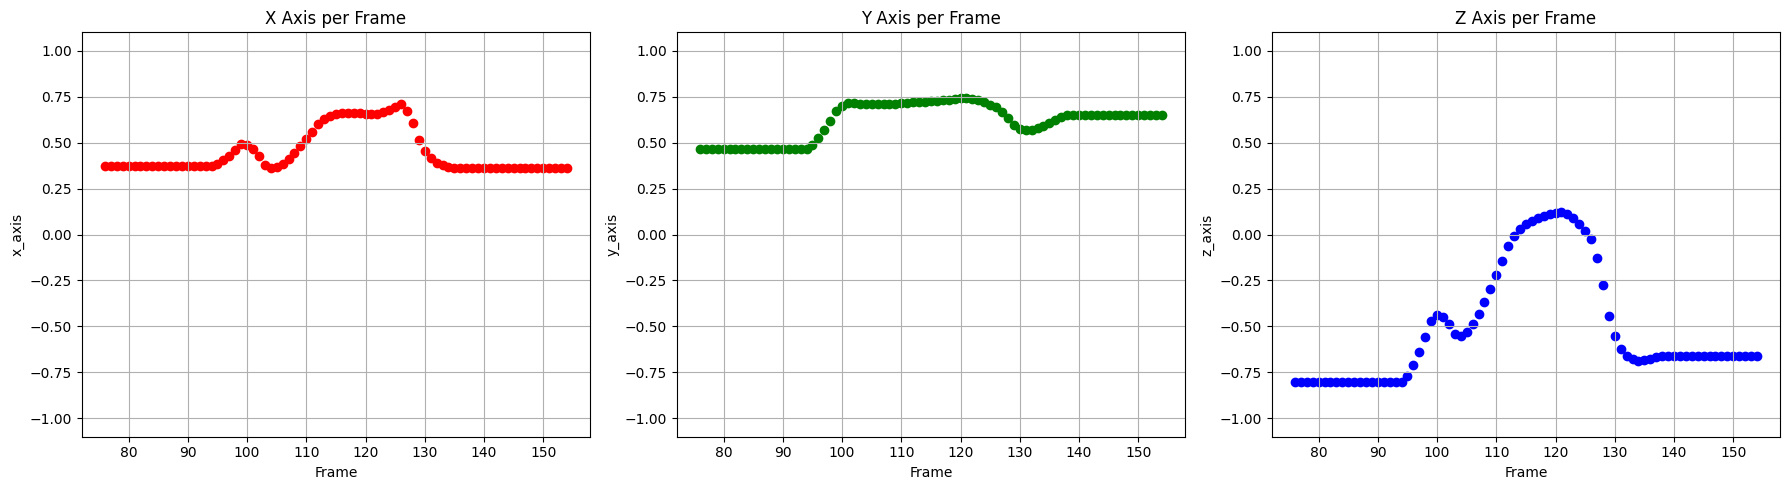

In [17]:
# Parameters
span=5

# Exponential Moving Average (EMA)
smoothed_df = result_df.copy()
smoothed_df['x_axis'] = smoothed_df['x_axis'].ewm(span=span, adjust=False).mean()
smoothed_df['y_axis'] = smoothed_df['y_axis'].ewm(span=span, adjust=False).mean()
smoothed_df['z_axis'] = smoothed_df['z_axis'].ewm(span=span, adjust=False).mean()

# Smoothed result
show_plots(smoothed_df)

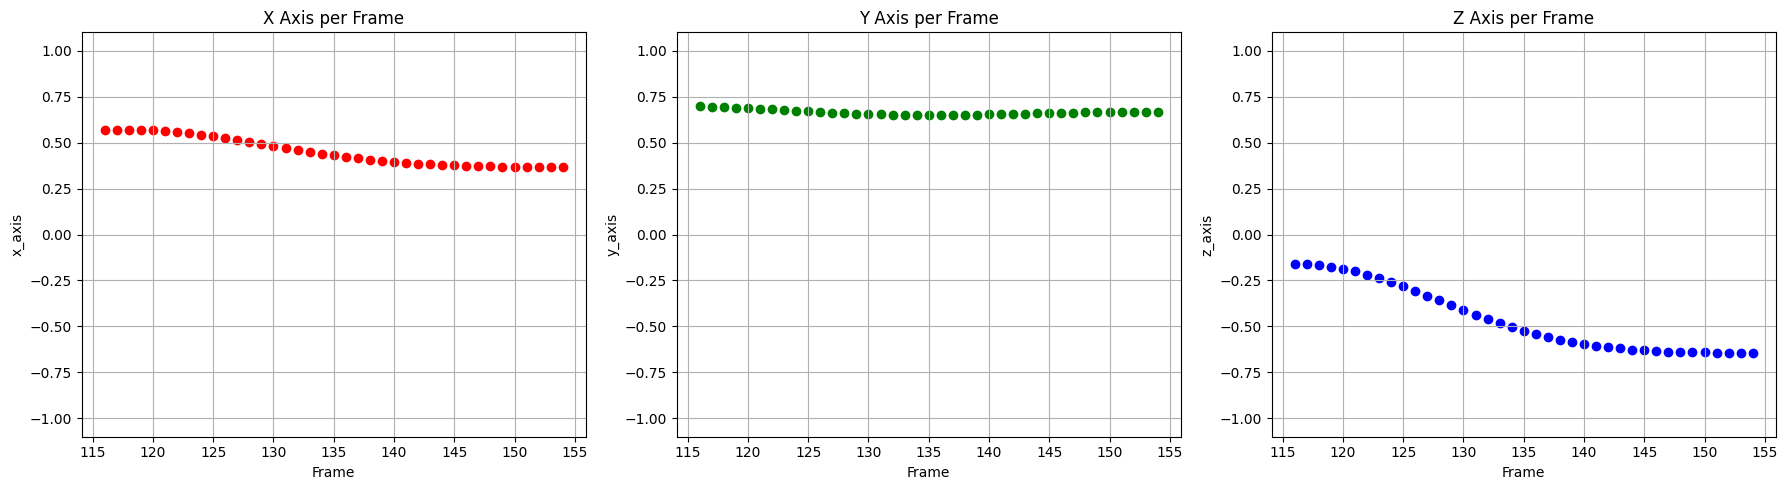

In [18]:
from scipy.ndimage import gaussian_filter1d

# Parameters
sigma=10

# Copy and interpolate missing values
smoothed_df = result_df.copy()
smoothed_df['x_axis'] = gaussian_filter1d(smoothed_df['x_axis'].interpolate(), sigma=sigma)
smoothed_df['y_axis'] = gaussian_filter1d(smoothed_df['y_axis'].interpolate(), sigma=sigma)
smoothed_df['z_axis'] = gaussian_filter1d(smoothed_df['z_axis'].interpolate(), sigma=sigma)

# Smoothed result
show_plots(smoothed_df)

In [19]:
def nullify_invalid_frames(A, B):

    # Identify frames in B where both x and y are NaN
    invalid_frames = B[B['x'].isna() & B['y'].isna()]['frame'].unique()

    # Copy A to avoid modifying original
    A_modified = A.copy()

    # Mask rows in A with frames that are invalid
    mask = A_modified['frame'].isin(invalid_frames)

    # Set all columns x_axis, y_axis, z_axis, angle to NaN for those rows
    A_modified.loc[mask, ['x_axis', 'y_axis', 'z_axis', 'angle']] = np.nan

    return A_modified

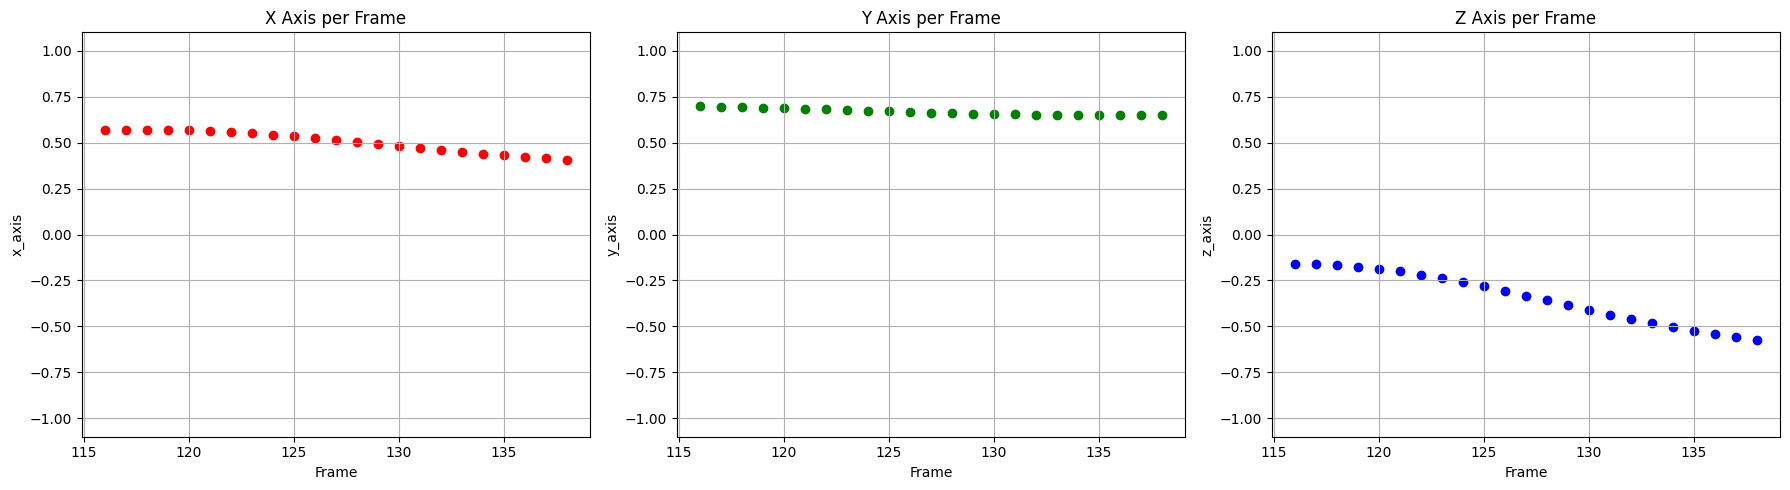

In [20]:
smoothed_df = nullify_invalid_frames(smoothed_df, df_original)

show_plots(smoothed_df)

In [21]:
smoothed_df.head()

,frame,x,y,radius,x_axis,y_axis,z_axis,angle
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
def scale_x_axis(df):
    df = df.copy()

    # Get index and values of first and last valid x_axis
    valid_x = df['x_axis'].dropna()
    if valid_x.empty:
        return df  # nothing to scale

    first_idx = valid_x.index[0]
    last_idx = valid_x.index[-1]
    x_start = valid_x.iloc[0]
    x_end = 1 / valid_x.iloc[-1]
    num_rows = last_idx - first_idx + 1

    # Generate scale factors
    scale_factors = np.linspace(x_start, x_end, num_rows)

    # Apply scaling
    df.loc[first_idx:last_idx, 'x_axis'] = df.loc[first_idx:last_idx, 'x_axis'] * scale_factors

    return df

def scale_y_axis(df):
    df = df.copy()

    # Get index and values of first and last valid y_axis
    valid_y = df['y_axis'].dropna()
    if valid_y.empty:
        return df  # nothing to scale

    first_idx = valid_y.index[0]
    last_idx = valid_y.index[-1]
    y_start = 1
    y_end = 0
    num_rows = last_idx - first_idx + 1

    # Generate scale factors from y_start to y_end
    scale_factors = np.linspace(y_start, y_end, num_rows)

    # Apply scaling
    df.loc[first_idx:last_idx, 'y_axis'] = df.loc[first_idx:last_idx, 'y_axis'] * scale_factors

    return df


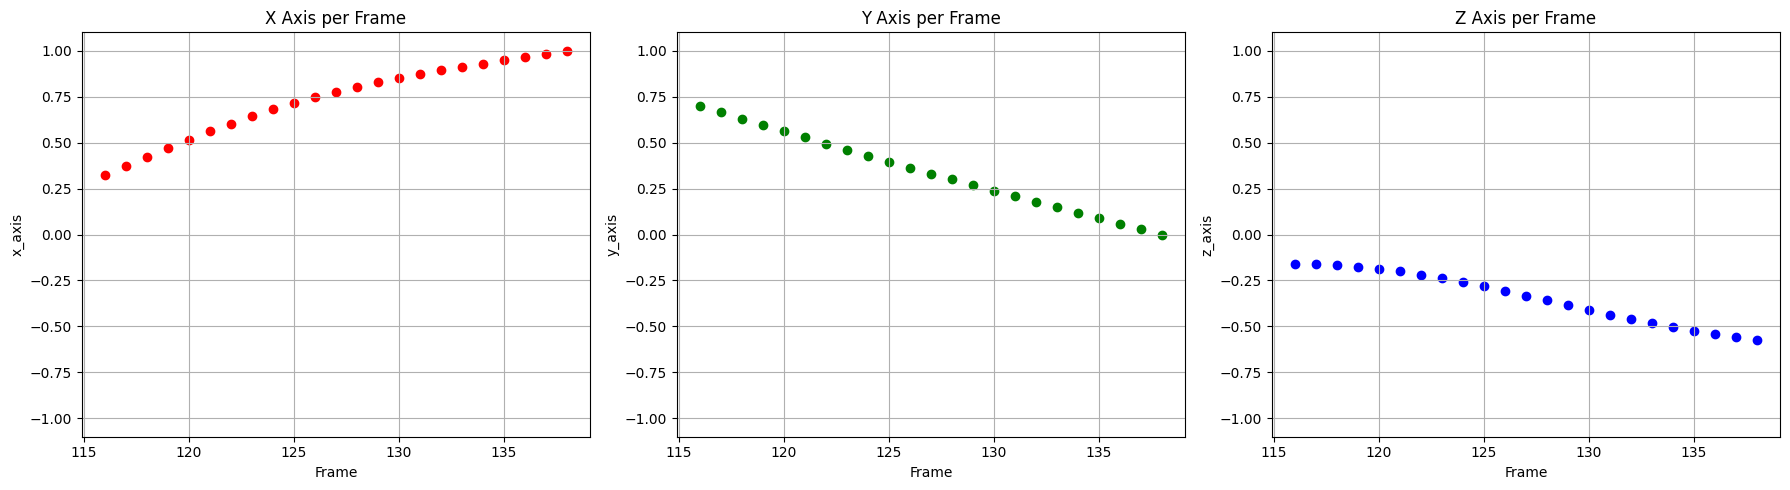

In [23]:
df_scaled = scale_x_axis(smoothed_df)
df_scaled = scale_y_axis(df_scaled)

show_plots(df_scaled)

In [24]:
def compute_z_axis_from_xy(df):
    df = df.copy()
    
    # Compute 1 - x^2 - y^2
    squared_sum = df['x_axis']**2 + df['y_axis']**2
    z_values = 1 - squared_sum

    # Handle invalid values (e.g., where 1 - x^2 - y^2 < 0)
    z_values[z_values < 0] = np.nan

    # Calculate z = sqrt(1 - x^2 - y^2)
    if y_axis_avg < 0:
        df['z_axis'] = np.sqrt(z_values)
    else:
        df['z_axis'] = -np.sqrt(z_values)

    return df

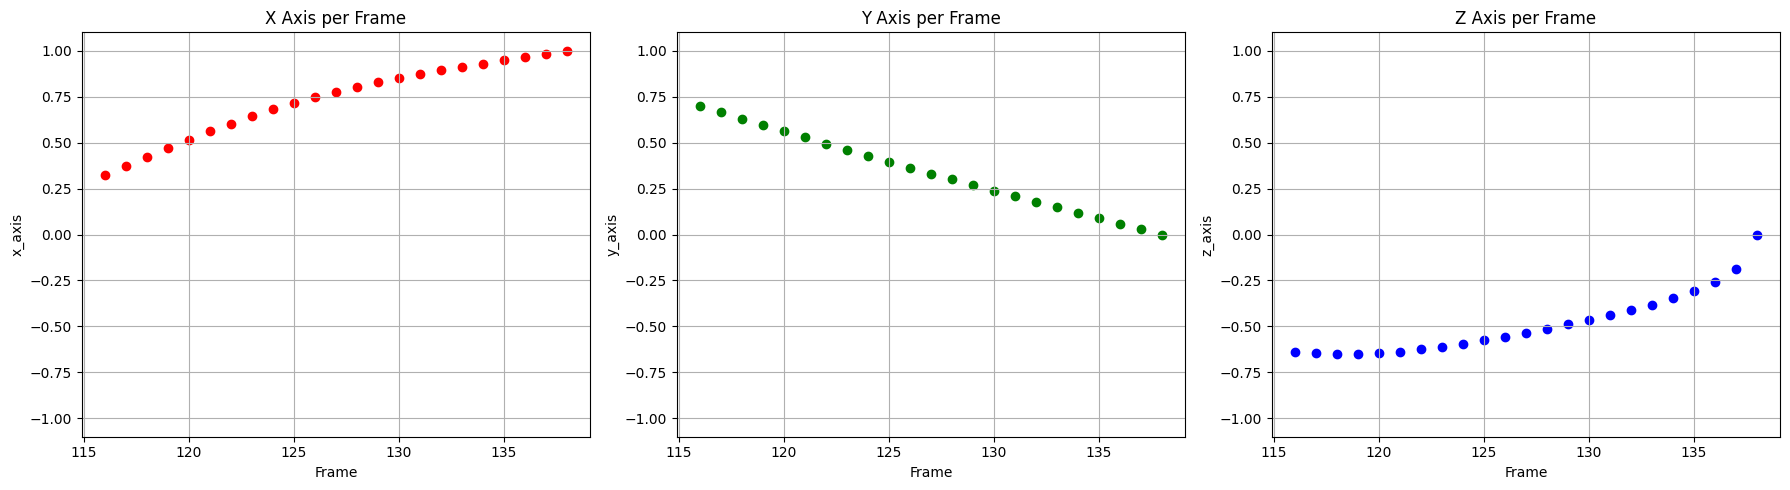

In [25]:
df_processed = compute_z_axis_from_xy(df_scaled)

show_plots(df_processed)

In [26]:
df_processed.head

<bound method NDFrame.head of      frame   x   y  radius  x_axis  y_axis  z_axis  angle
0        0 NaN NaN     NaN     NaN     NaN     NaN    NaN
1        1 NaN NaN     NaN     NaN     NaN     NaN    NaN
2        2 NaN NaN     NaN     NaN     NaN     NaN    NaN
3        3 NaN NaN     NaN     NaN     NaN     NaN    NaN
4        4 NaN NaN     NaN     NaN     NaN     NaN    NaN
..     ...  ..  ..     ...     ...     ...     ...    ...
150    150 NaN NaN     NaN     NaN     NaN     NaN    NaN
151    151 NaN NaN     NaN     NaN     NaN     NaN    NaN
152    152 NaN NaN     NaN     NaN     NaN     NaN    NaN
153    153 NaN NaN     NaN     NaN     NaN     NaN    NaN
154    154 NaN NaN     NaN     NaN     NaN     NaN    NaN

[155 rows x 8 columns]>

### Post-processing angle

In [27]:
def plot_angle_over_index(df, title="Angle Over Index"):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['angle'], label='Angle', color='blue')
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Angle (rad)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [28]:
def remove_outliers(series, threshold=1):
    # Apply an outlier removal using z-score
    mean = series.mean()
    std = series.std()
    z_scores = (series - mean) / std
    outliers_z = abs(z_scores) > threshold  # Consider values with z-score > threshold as outliers
    series[outliers_z] = np.nan

    return series

In [29]:
def smooth_series(series, first_valid_index, last_valid_index, window=5):
    # Copia per non modificare l'originale
    smoothed = series.copy()

    # Applichi il rolling solo tra i validi
    rolled = series[first_valid_index:last_valid_index+1] \
        .rolling(window=window, center=True) \
        .mean()

    # Interpolazione per stimare i bordi più precisamente
    rolled = rolled.interpolate(method='cubic', limit_direction='both').fillna(method='bfill').fillna(method='ffill')

    smoothed[first_valid_index:last_valid_index+1] = rolled

    # Rimetti i valori smussati nella serie originale
    series.loc[first_valid_index:last_valid_index] = smoothed
    return series

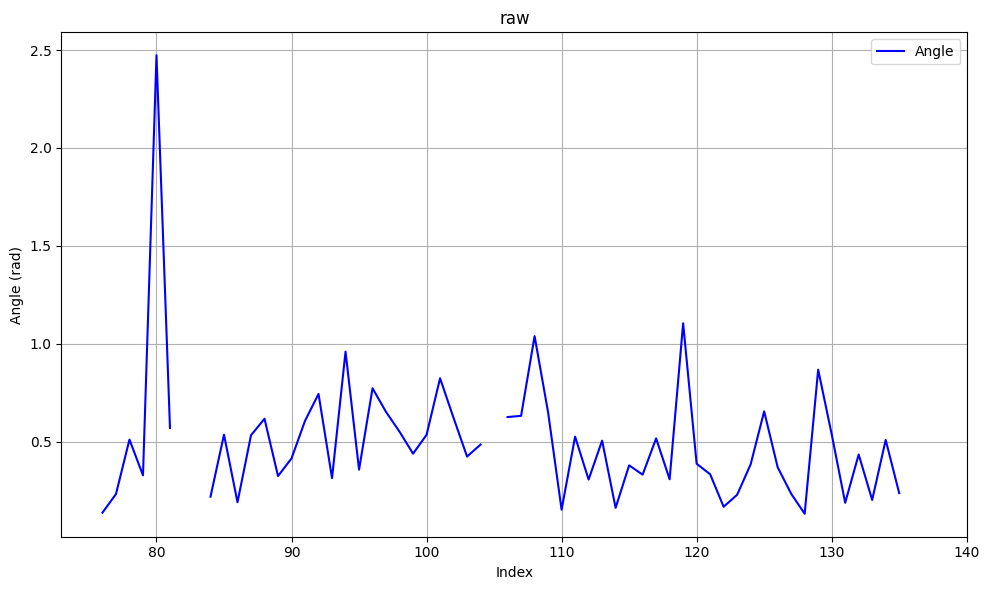

In [30]:
plot_angle_over_index(df, title="raw")

/tmp/ipykernel_1003/3499710534.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[outliers_z] = np.nan


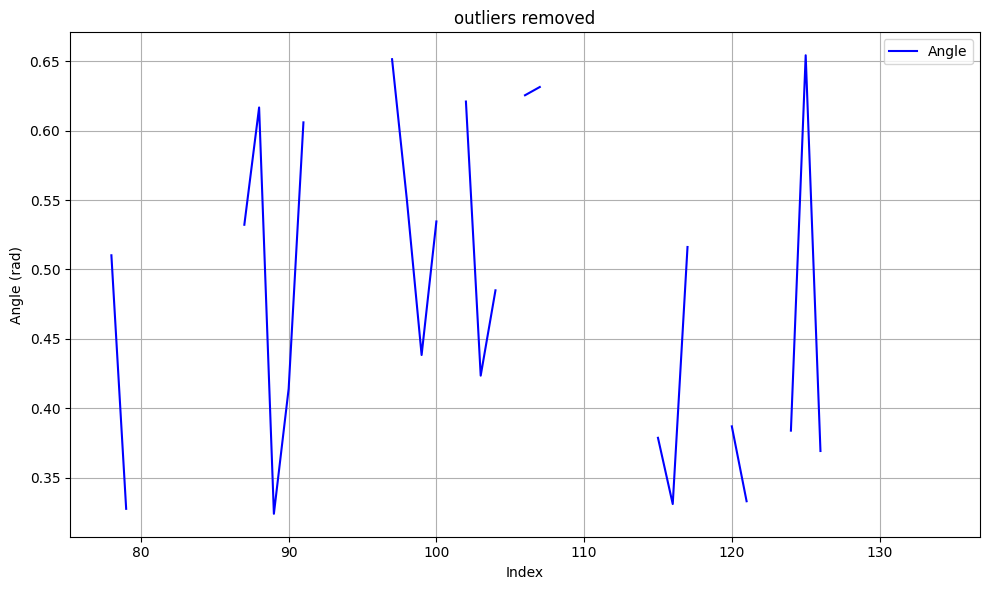

In [31]:
# Remove outliers
df['angle'] = remove_outliers(df['angle'], threshold=0.5)
plot_angle_over_index(df, title="outliers removed")

First valid index: 76, Last valid index: 137


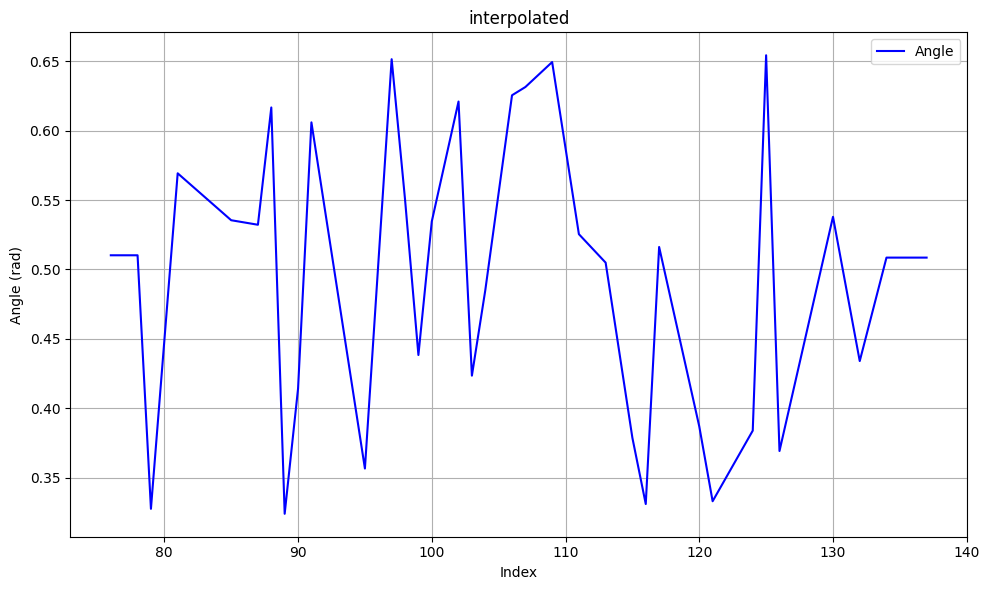

In [32]:
# Find the first and last non-NaN indices
first_valid_index = df_processed['x'].first_valid_index()
last_valid_index = df_processed['x'].last_valid_index()
print(f"First valid index: {first_valid_index}, Last valid index: {last_valid_index}")
# Only interpolate between them
df.loc[first_valid_index:last_valid_index, 'angle'] = (
    df.loc[first_valid_index:last_valid_index, 'angle']
    .interpolate(method='linear', limit_direction='both')
)
plot_angle_over_index(df, title="interpolated")

/tmp/ipykernel_1003/4293600903.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolled = rolled.interpolate(method='cubic', limit_direction='both').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1003/4293600903.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[first_valid_index:last_valid_index] = smoothed


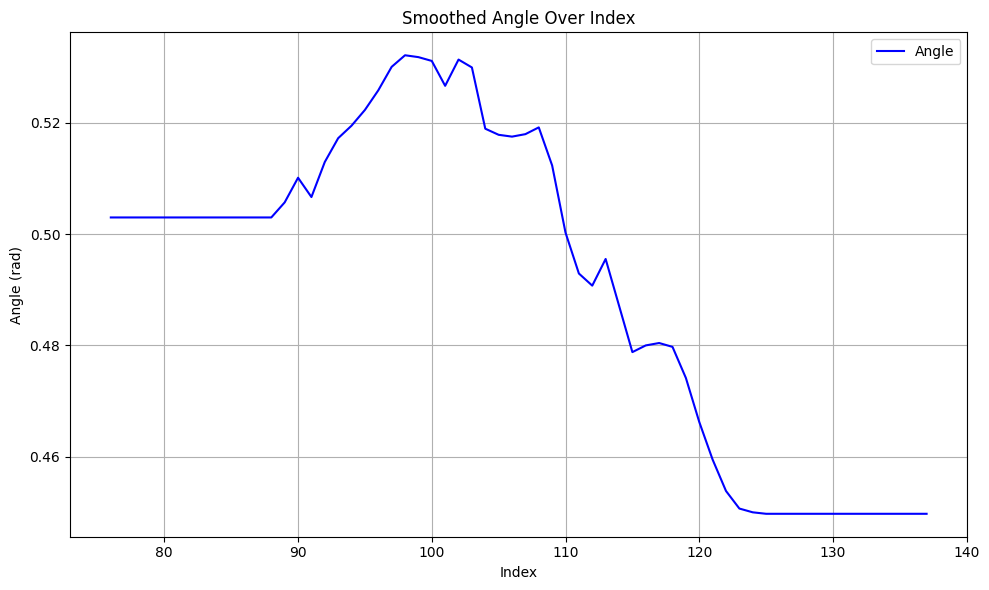

In [33]:
# Smooth the data
df['angle'] = smooth_series(df['angle'], first_valid_index, last_valid_index, window=25)

plot_angle_over_index(df, title="Smoothed Angle Over Index")

/tmp/ipykernel_1003/4293600903.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolled = rolled.interpolate(method='cubic', limit_direction='both').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1003/4293600903.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[first_valid_index:last_valid_index] = smoothed


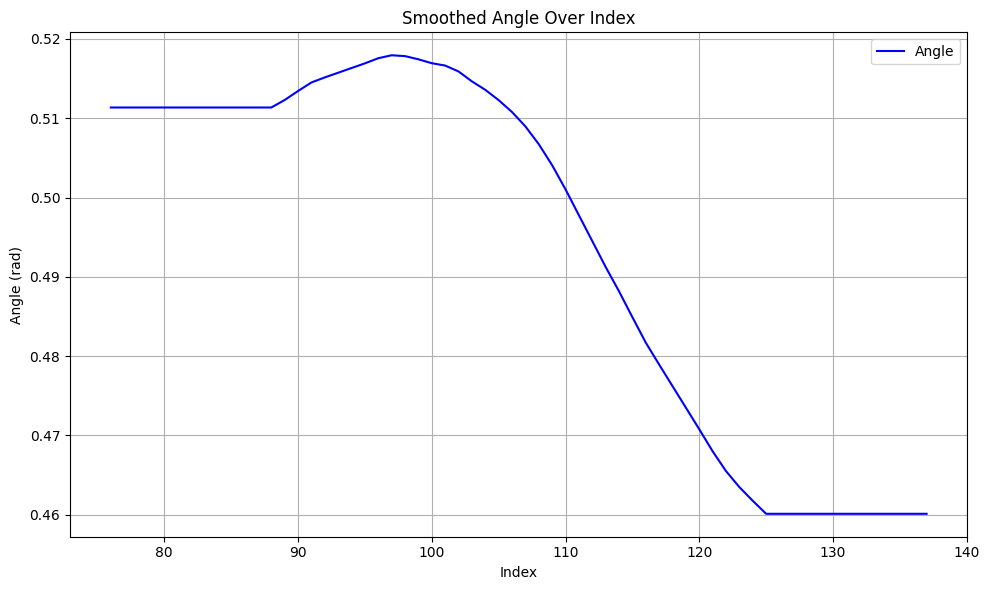

In [34]:
# Smooth the data
df['angle'] = smooth_series(df['angle'], first_valid_index, last_valid_index, window=25)

plot_angle_over_index(df, title="Smoothed Angle Over Index")

In [35]:
df_processed['angle'] = df['angle']
df_processed.head

<bound method NDFrame.head of      frame   x   y  radius  x_axis  y_axis  z_axis  angle
0        0 NaN NaN     NaN     NaN     NaN     NaN    NaN
1        1 NaN NaN     NaN     NaN     NaN     NaN    NaN
2        2 NaN NaN     NaN     NaN     NaN     NaN    NaN
3        3 NaN NaN     NaN     NaN     NaN     NaN    NaN
4        4 NaN NaN     NaN     NaN     NaN     NaN    NaN
..     ...  ..  ..     ...     ...     ...     ...    ...
150    150 NaN NaN     NaN     NaN     NaN     NaN    NaN
151    151 NaN NaN     NaN     NaN     NaN     NaN    NaN
152    152 NaN NaN     NaN     NaN     NaN     NaN    NaN
153    153 NaN NaN     NaN     NaN     NaN     NaN    NaN
154    154 NaN NaN     NaN     NaN     NaN     NaN    NaN

[155 rows x 8 columns]>

In [36]:
OUTPUT_CSV_PATH = str(PROJECT_ROOT / "notebook" / "spin" / "intermediate_data" / f"Rotation_data_processed_{VIDEO_NUMBER}.csv")
df_processed.to_csv(OUTPUT_CSV_PATH, index=False)
print(f"Saved rotation data to {OUTPUT_CSV_PATH}")

Saved rotation data to /home/davic/projects/IACV_project/bowling-analysis/notebook/spin/intermediate_data/Rotation_data_processed_5.csv
